In [1]:
import numpy as np
from PIL import Image
import sys 
from scipy import signal
import pyVHR as vhr
import pickle
import torch
import matplotlib.pyplot as plt

2022-09-05 12:10:30.840508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
PATCH_SIZE = 16
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 12
BLOCKS = 12
BATCH = 300
LENGTH = 160

In [3]:
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'
    
#SET DATASET

dataset_name = 'vipl_hr_v1'           
video_DIR = '/var/datasets/VHR1'  
BVP_DIR = '/var/datasets/VHR1'    

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

def getVideo(idx):
    wsize = 8          
    video_idx = idx     
    fname = dataset.getSigFilename(video_idx)
    sigGT = dataset.readSigfile(fname)
    #train_bvp = [sigGT.data[0][i] for i in range(0,len(sigGT.data[0])-1,2)]
    #bpmGT, timesGT = sigGT.getBPM(wsize)
    videoFileName = dataset.getVideoFilename(video_idx)
    fps = vhr.extraction.get_fps(videoFileName)
    #vhr.plot.display_video(videoFileName)
    return videoFileName, fps, sigGT

In [4]:
#SKIN EXTRACTION AND VISUALIZATION
def patches_extraction(videFileName, fps):
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.display_cuda_device()
    sig_extractor.choose_cuda_device(0)
    
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))
    seconds = 0
    sig_extractor.set_total_frames(seconds*fps)

    vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254
    vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254

    sig_extractor.set_visualize_skin_and_landmarks(
          visualize_skin=True, 
          visualize_landmarks=True, 
          visualize_landmarks_number=True, 
          visualize_patch=True)

    landmarks = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, \
             58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, \
             118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, \
             210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, \
             284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, \
             346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]

    
    sig_extractor.set_landmarks(landmarks)

    #PATCHES EXTRACTION
    sig_extractor.set_square_patches_side(PATCH_SIZE + 0.0)
    patch_sig = sig_extractor.extract_patches(videoFileName, "squares", "mean")
    visualize_patches_coll = sig_extractor.get_visualize_patches()
    patches = sig_extractor.patches

    return patches

In [20]:
def weaver(patches, sigGT):
    train_bvp = signal.resample(sigGT.data[0], len(patches)).astype(int)

    #for each frame concatenate patches in one image
    webs = []

    for f_p in patches:
        if len(f_p)==100:
            tmp=np.concatenate(f_p[0:10])
            for i in range(10,len(f_p),10):
                r=np.concatenate(f_p[i:i+10])
                tmp=np.concatenate((tmp,r),axis=1)
            if webs==[]:
                webs = torch.unsqueeze(torch.as_tensor(tmp),0)
            else:
                webs = torch.cat((webs,torch.unsqueeze(torch.as_tensor(tmp),0)))

    #inputs = torch.as_tensor(inputs)
    plt.imshow(webs[0])
    plt.show()
    return webs, train_bvp

In [6]:
def write_webs(video_idx,webs,train_bvp):
    with open('/var/datasets/VIPL-HR-V1_webs/'+str(video_idx)+'-WEBS-'+str(PATCH_SIZE), 'wb') as f:
        pickle.dump((webs,train_bvp), f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
videoFileName, fps, sigGT = getVideo(0)
patches = patches_extraction(videoFileName, fps)

# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TypeError: Invalid shape (100, 16, 16, 3) for image data

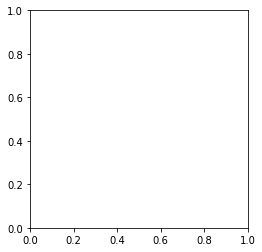

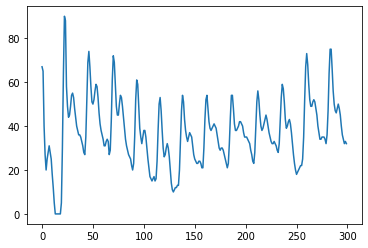

In [14]:
plt.plot(train_bvp[0:300])
plt.show()

total  957
INDEX  15
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p30/v2/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  970 100 (16, 16, 3)


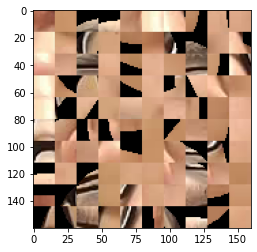

INDEX  16
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p30/v4/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1073 100 (16, 16, 3)


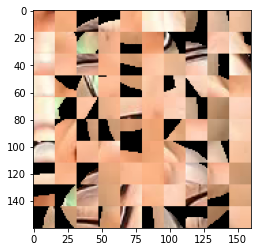

INDEX  17
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p30/v1/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  943 100 (16, 16, 3)


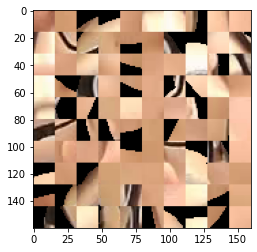

INDEX  18
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v8/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  926 100 (16, 16, 3)


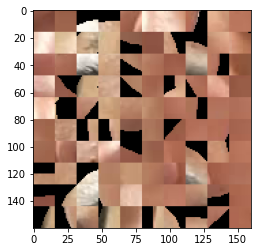

INDEX  19
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v9/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  905 100 (16, 16, 3)


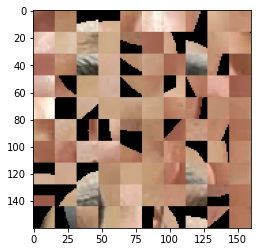

INDEX  20
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v3/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  961 100 (16, 16, 3)


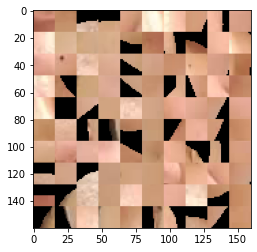

INDEX  21
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v7/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1013 100 (16, 16, 3)


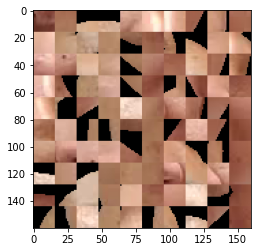

INDEX  22
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v6/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  955 100 (16, 16, 3)


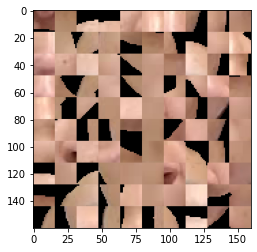

INDEX  23
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v5/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  889 100 (16, 16, 3)


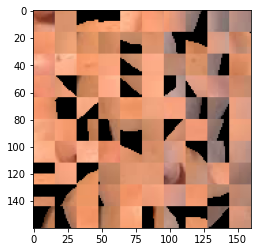

INDEX  24
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v2/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  972 100 (16, 16, 3)


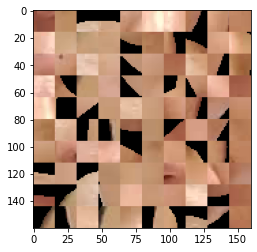

INDEX  25
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v4/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  891 100 (16, 16, 3)


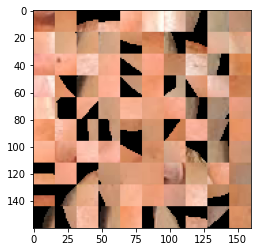

INDEX  26
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p52/v1/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1075 100 (16, 16, 3)


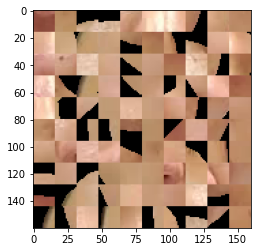

INDEX  27
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v8/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  950 100 (16, 16, 3)


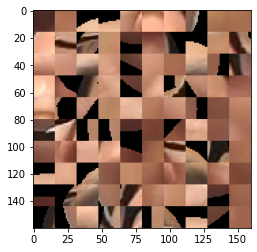

INDEX  28
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v9/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1028 100 (16, 16, 3)


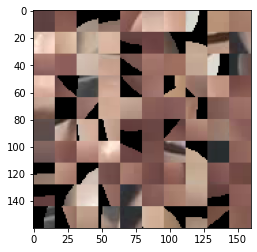

INDEX  29
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v3/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  967 100 (16, 16, 3)


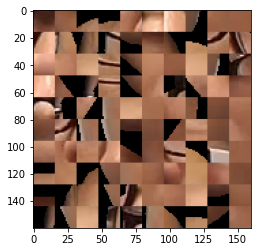

INDEX  30
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v7/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  995 100 (16, 16, 3)


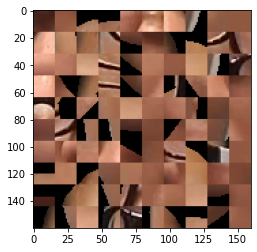

INDEX  31
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v6/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1006 100 (16, 16, 3)


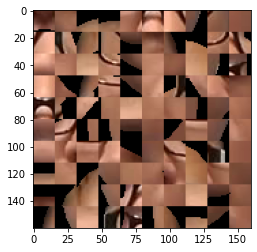

INDEX  32
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v5/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  881 100 (16, 16, 3)


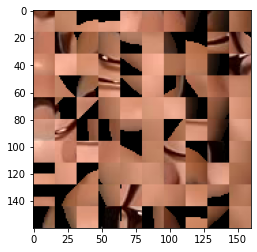

INDEX  33
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v2/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  963 100 (16, 16, 3)


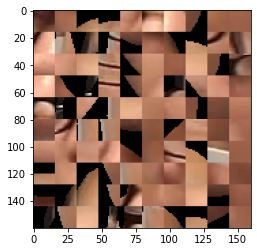

INDEX  34
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v4/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  995 100 (16, 16, 3)


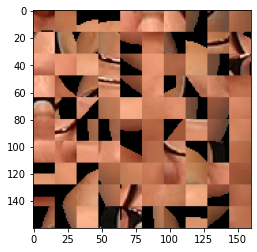

INDEX  35
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p76/v1/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  964 100 (16, 16, 3)


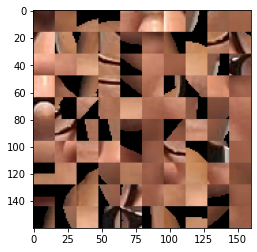

INDEX  36
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v8/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1027 100 (16, 16, 3)


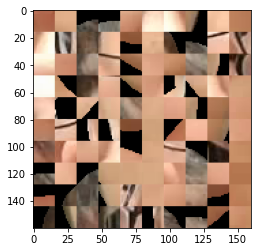

INDEX  37
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v9/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  938 100 (16, 16, 3)


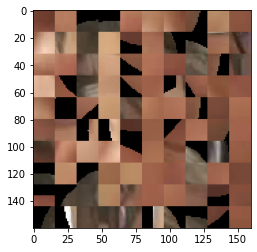

INDEX  38
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v3/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  971 100 (16, 16, 3)


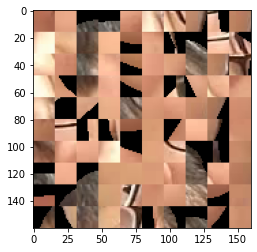

INDEX  39
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v7/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  983 100 (16, 16, 3)


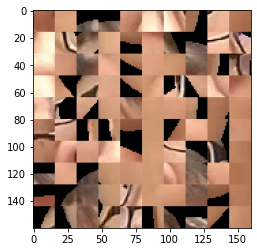

INDEX  40
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v6/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  991 100 (16, 16, 3)


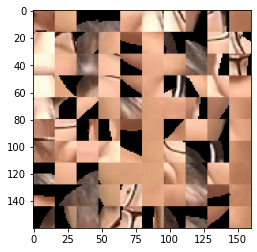

INDEX  41
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v5/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  884 100 (16, 16, 3)


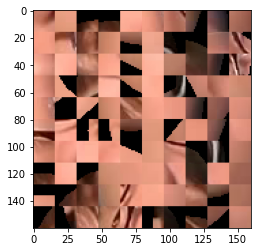

INDEX  42
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v2/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  914 100 (16, 16, 3)


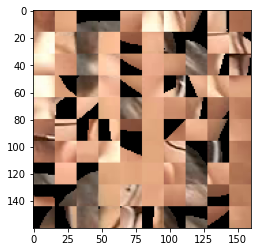

INDEX  43
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v4/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  987 100 (16, 16, 3)


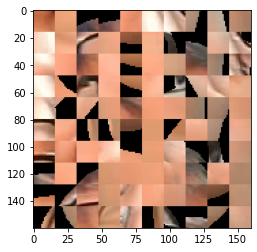

INDEX  44
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p96/v1/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  937 100 (16, 16, 3)


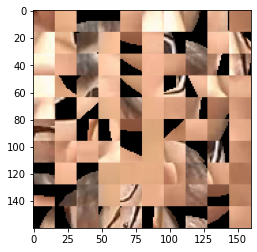

INDEX  45
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p29/v8/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1143 100 (16, 16, 3)


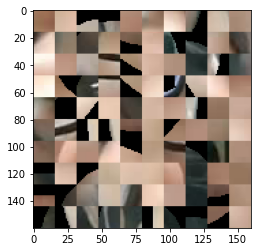

INDEX  46
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p29/v9/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  1011 100 (16, 16, 3)


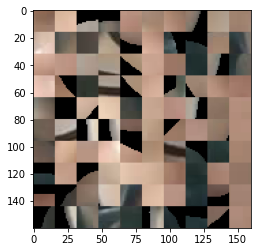

INDEX  47
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p29/v3/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  955 100 (16, 16, 3)


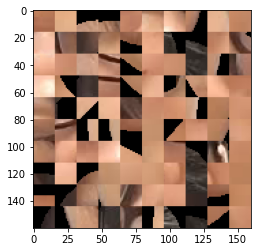

INDEX  48
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p29/v7/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  935 100 (16, 16, 3)


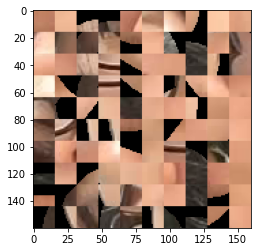

INDEX  49
Video processed name: /var/datasets/VHR1/VIPL_HR_V1_source2/p29/v6/video.avi
Video frame rate:     25.0
# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB
patches:  909 100 (16, 16, 3)


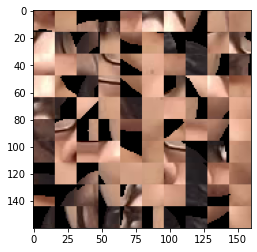

In [22]:
print("total ", len(allvideo))
for idx in range(15,50):
    print("INDEX ",idx)
    videoFileName, fps, sigGT = getVideo(idx)
    print(f'Video processed name: {videoFileName}\nVideo frame rate:     {fps}')
    patches = patches_extraction(videoFileName, fps)
    print("patches: ", len(patches), len(patches[0]), patches[0][0].shape)
    webs, train_bvp = weaver(patches, sigGT)
    write_webs(idx, webs, train_bvp)

In [8]:
a =[]
for idx in range(0,50):
    with open('/var/datasets/PURE_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE), 'rb') as f:
        (webs,train_bvp) = pickle.load(f)
        a.append(len(webs))
        
print(min(a))

1950
